In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [30]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el pipeline sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

In [31]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [32]:
# Representación gráfica del límite de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [33]:
df = pd.read_csv("/home/aluvesprada/Documentos/saa/notebooks_saa/Notebooks-20250114/Datasets-20250115/card_transdata.csv")

In [34]:
df.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [35]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [37]:
df["fraud"].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

In [38]:
print(df[['distance_from_home', 'ratio_to_median_purchase_price']].isnull().sum())


distance_from_home                0
ratio_to_median_purchase_price    0
dtype: int64


In [39]:
is_null = df.isna().any()
is_null[is_null]

Series([], dtype: bool)

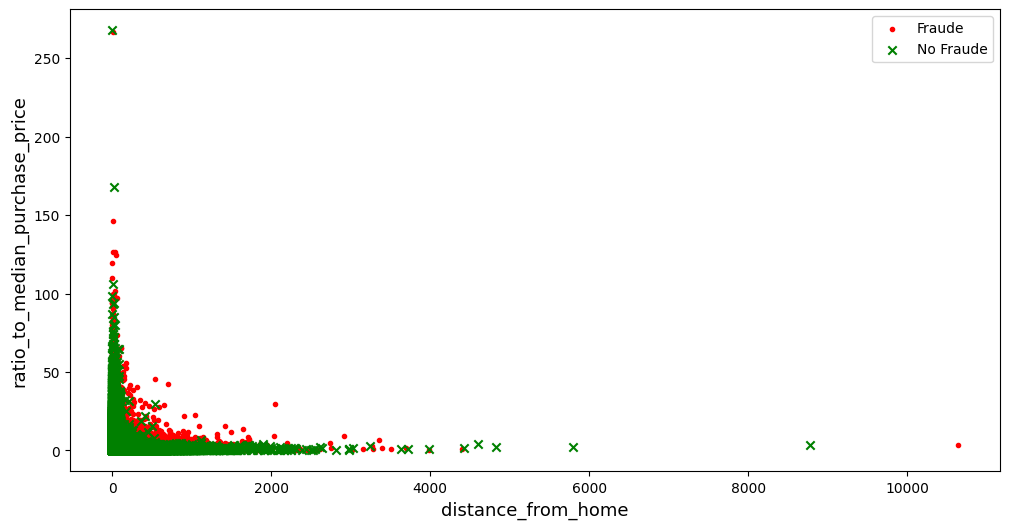

In [40]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(
    df["distance_from_home"][df['fraud'] == 1.0],  # Valores numéricos para fraude
    df["ratio_to_median_purchase_price"][df['fraud'] == 1.0],
    c="r", marker=".", label="Fraude"
)
plt.scatter(
    df["distance_from_home"][df['fraud'] == 0.0],  # Valores numéricos para no fraude
    df["ratio_to_median_purchase_price"][df['fraud'] == 0.0],
    c="g", marker="x", label="No Fraude"
)
plt.xlabel("distance_from_home", fontsize=13)
plt.ylabel("ratio_to_median_purchase_price", fontsize=13)
plt.legend()
plt.show()


In [41]:
# División del conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [42]:
X_train = train_set.drop("fraud", axis=1)
y_train = train_set["fraud"].copy()

X_val = val_set.drop("fraud", axis=1)
y_val = val_set["fraud"].copy()

X_test = test_set.drop("fraud", axis=1)
y_test = test_set["fraud"].copy()

In [43]:
X_train.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,26.575562,5.014101,1.828696,0.881768,0.349825,0.100640,0.650182
std,64.459816,22.925837,2.812139,0.322883,0.476915,0.300852,0.476913
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000
25%,3.885328,0.297907,0.476195,1.000000,0.000000,0.000000,0.000000
50%,9.962113,0.998508,0.998576,1.000000,0.000000,0.000000,1.000000
75%,25.692481,3.357682,2.095959,1.000000,1.000000,0.000000,1.000000
max,5797.972589,4968.315477,266.689692,1.000000,1.000000,1.000000,1.000000


In [44]:
# Verificar si hay valores infinitos en el conjunto de datos
infinite_cols = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()

print(f"Columnas con valores infinitos: {infinite_cols}")


Columnas con valores infinitos: []


In [45]:
# Rellenamos los valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [46]:
# Rellenamos los valores nulos
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)

In [47]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [48]:
X_train_prep.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
333136,17.213366,1.298194,1.678790,1.0,0.0,0.0,1.0
515905,4.327013,17.705887,0.823981,1.0,1.0,0.0,1.0
230477,48.175939,0.823088,3.312058,1.0,0.0,0.0,1.0
967322,18.220166,1.870733,0.409861,1.0,1.0,0.0,1.0
610942,3.843726,0.486490,2.000089,1.0,0.0,0.0,1.0
746682,74.442687,0.639851,0.287617,1.0,1.0,0.0,1.0
578643,5.203606,3.877377,0.671933,1.0,0.0,0.0,0.0
907637,13.496805,3.813035,2.532976,1.0,0.0,0.0,0.0
906852,4.216238,0.431128,0.110605,1.0,0.0,0.0,0.0
833842,6.679782,0.013733,0.292056,1.0,0.0,0.0,1.0


In [49]:
# Comprobamos si hay valores nulos en el conjunto de datos de entrenamiento
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

In [50]:
X_train_reduced = X_train_prep[["distance_from_home", "ratio_to_median_purchase_price"]].copy()
X_val_reduced = X_val_prep[["distance_from_home", "ratio_to_median_purchase_price"]].copy()
print(f"Tamaño del conjunto de entrenamiento reducido: {X_train_reduced.shape}")
print(f"Tamaño del conjunto de validación reducido: {X_val_reduced.shape}")

Tamaño del conjunto de entrenamiento reducido: (600000, 2)
Tamaño del conjunto de validación reducido: (200000, 2)


In [116]:
# Tomar una muestra aleatoria del conjunto de entrenamiento y validación
X_train_reduced_sample = X_train_reduced.sample(n=5000, random_state=42)
y_train_reduced_sample = y_train.loc[X_train_reduced_sample.index]

X_val_reduced_sample = X_val_reduced.sample(n=2000, random_state=42)
y_val_reduced_sample = y_val.loc[X_val_reduced_sample.index]

print(f"Tamaño del conjunto de entrenamiento reducido (muestra): {X_train_reduced_sample.shape}")
print(f"Tamaño del conjunto de validación reducido (muestra): {X_val_reduced_sample.shape}")


Tamaño del conjunto de entrenamiento reducido (muestra): (5000, 2)
Tamaño del conjunto de validación reducido (muestra): (2000, 2)


In [117]:
X_train_reduced_sample

,distance_from_home,ratio_to_median_purchase_price
407535,3.169916,4.222832
355277,19.696732,0.656991
818575,2.265744,3.163714
64023,30.253119,0.672588
288871,14.990618,2.280548
...,...,...
841189,8.428700,1.277879
663088,359.226867,0.870039
807962,21.303545,0.102955
799464,61.494726,0.281812


In [118]:
from sklearn.svm import SVC

# SVM Large Margin Classification
svm_clf = SVC(kernel="linear", C=50)
svm_clf.fit(X_train_reduced_sample, y_train_reduced_sample)

SVC(C=50, kernel='linear')

In [119]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

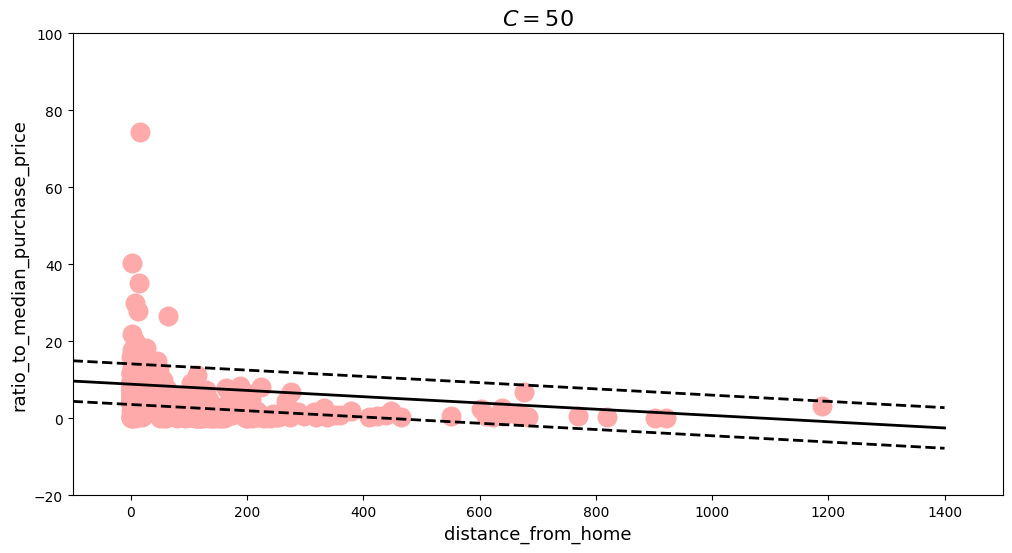

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced_sample.values[:, 0][y_train_reduced_sample=="1.0"], X_train_reduced_sample.values[:, 1][y_train_reduced_sample=="1.0"], "g^")
plt.plot(X_train_reduced_sample.values[:, 0][y_train_reduced_sample=="0.0"], X_train_reduced_sample.values[:, 1][y_train_reduced_sample=="0.0"], "bs")
plot_svc_decision_boundary(svm_clf, -100, 1400)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([-100, 1500, -20, 100])
plt.xlabel("distance_from_home", fontsize=13)
plt.ylabel("ratio_to_median_purchase_price", fontsize=13)
plt.show()

In [121]:
y_pred = svm_clf.predict(X_val_reduced)

In [122]:
from sklearn.metrics import f1_score

print("F1 Score:", f1_score(y_val, y_pred, pos_label=1))


F1 Score: 0.279082224801357
